# Understand effect of tilts on transverse widths

In this example we'll generate points distributed according to a 3D normal PDF with known widths and rotated wrt CMS reference frame. In this way we know exactly the proper widths of the ellipsoid.

Then we'll fit this distribution using the standard CMS beam spot formalism - which is again a 3D normal PDF, but expressed such that all quantities are explicitly referred to the CMS system - and check how the effective widths (what we've so far provided as $\sigma_x$ and $\sigma_y$) differ from the proper widths.

In [2]:
import iminuit
import numpy as np
import seaborn as sns
from math import pi
from matplotlib import pyplot as plt
from scipy.stats import multivariate_normal

## Define 3D gaussian likelihood
In this version we design the covariance matrix as $\Sigma_{\textrm{beam}}^{\textrm{CMS}} = R_T(\alpha, \beta, \gamma)\cdot \Sigma_{\textrm{beam}} \cdot R(\alpha, \beta, \gamma)$  
Where $\Sigma_{\textrm{beam}}$ is the diagonal matrix of the proper widths of the ellipsoid and $R(\alpha, \beta, \gamma)$ represents the rotations and the Euler angles.  

In [3]:
class MultivariateGaussianFitterNLL():
    '''
    Fit 3D gaussian cloud.
    '''
    def __init__(self, events, uncertainties=None, verbose=False):
        self.events  = events
        self.verbose = verbose

    @staticmethod
    def _compute_covariance_matrix(theta_x, theta_y, theta_z, sigma_x, sigma_y, sigma_z):
        '''
        https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Density_function
        Generate covariance matrix by applying rotations to the diagonal 3x3 matrix of widths.
        '''
        rot_x = np.matrix([
            [ 1., 0.             ,  0.             ],
            [ 0., np.cos(theta_x), -np.sin(theta_x)],
            [ 0., np.sin(theta_x),  np.cos(theta_x)],
        ]).astype(np.float64)
        
        rot_y = np.matrix([
            [  np.cos(theta_y), 0., np.sin(theta_y)],
            [  0.             , 1., 0.             ],
            [ -np.sin(theta_y), 0., np.cos(theta_y)],
        ]).astype(np.float64)
    
        rot_z = np.matrix([
            [ np.cos(theta_z), -np.sin(theta_z), 0.],
            [ np.sin(theta_z),  np.cos(theta_z), 0.],
            [ 0.             ,  0.             , 1.],
        ]).astype(np.float64)
        
        widths = np.matrix([
            [ np.power(sigma_x, 2), 0.                  , 0.                  ],
            [ 0.                  , np.power(sigma_y, 2), 0.                  ],
            [ 0.                  , 0.                  , np.power(sigma_z, 2)],
        ]).astype(np.float64)
        
        cov = (rot_x * (rot_y * (rot_z * widths * rot_z.T) * rot_y.T) * rot_x.T)
        
        return cov
                
    def nll(self, x, y, z, theta_x, theta_y, theta_z, sigma_x, sigma_y, sigma_z):
        '''
        Compute the likelihood of a set of parameters
            x        ==> diplacement of the centroid from the origin of the observer's reference frame
            y
            z
            theta_x  ==> Euler angles, rotation of the main axes of the ellipsoid wrt the observer's reference frame
            theta_y
            theta_z
            sigma_x  ==> proper widths of the ellipsoid
            sigma_y
            sigma_z
        given the data points.
        '''
        
        if self.verbose:
            print '\n=========='
            print 'x      :\t', x      , '[cm]'
            print 'y      :\t', y      , '[cm]'
            print 'z      :\t', z      , '[cm]'
            print 'theta_x:\t', theta_x, '[rad]'
            print 'theta_y:\t', theta_y, '[rad]'
            print 'theta_z:\t', theta_z, '[rad]'
            print 'sigma x:\t', sigma_x, '[cm]'
            print 'sigma y:\t', sigma_y, '[cm]'
            print 'sigma z:\t', sigma_z, '[cm]'

        cov = self._compute_covariance_matrix(theta_x, theta_y, theta_z, sigma_x, sigma_y, sigma_z)
        
        if self.verbose:
            print 'covariance matrix', cov
            print 'determinant: ', np.linalg.det(cov) 
        
        # check singularity / inveritbility
        if np.linalg.det(cov) > 0.:
            nll = -multivariate_normal.logpdf(self.events,
                                              mean=np.array([x, y, z]),
                                              cov=cov).sum()
        else:
            print 'WARNING! Singular covariance matrix, cannot invert!'
            return float('nan')

        if self.verbose:
            print 'nLL: ', nll
        
        return nll

We also define another version of the 3D gaussian likelihood, now à la CMS, that is  

$$
\Sigma_{\textrm{beam}}^{\textrm{CMS}} = 
 \begin{pmatrix}
  (\sigma_{x}^{\textrm{eff}})^2 & \sigma_{xy} & \sigma_{xz} \\
  \sigma_{xy}                   & (\sigma_{y}^{\textrm{eff}})^2 & \sigma_{yz} \\
  \sigma_{xz}                   & \sigma_{yz} & (\sigma_{z}^{\textrm{eff}})^2
 \end{pmatrix}
$$
  
where 
$$\sigma_{xy} = \rho \cdot \sigma_x^{eff} \sigma_y^{eff}$$
$$\sigma_{xz} = -\frac{dx}{dz} \cdot ((\sigma_z^{eff})^2 - (\sigma_x^{eff})^2)) - \frac{dy}{dz}\rho\sigma_x^{eff}\sigma_y^{eff} $$
$$\sigma_{yz} = -\frac{dy}{dz} \cdot ((\sigma_y^{eff})^2 - (\sigma_z^{eff})^2)) - \frac{dx}{dz}\rho\sigma_x^{eff}\sigma_y^{eff} $$

The last two conditions come from imposing that the off-diagonal elements must be 0 when the covariance matrix is rotated back to cancel the $dx/dz$ and $dy/dz$ tilts.

In [4]:
class AltMultivariateGaussianFitterNLL(MultivariateGaussianFitterNLL):
    '''
    Alternative parametrisation
    '''
    def nll(self, x, y, z, corrxy, sigma_x_eff, sigma_y_eff, sigma_z_eff, dxdz, dydz):
        '''
        Modeled on official CMS beam spot fit.
        https://github.com/cms-sw/cmssw/blob/master/RecoVertex/BeamSpotProducer/src/FcnBeamSpotFitPV.cc#L59
        
        Parameters of interest:
            x           ==> diplacement of the centroid from the origin of the observer's reference frame
            y           
            z           
            corrxy      ==> correlation strength between x and y
            sigma_x_eff ==> widths of the ellipsoid *as projected onto CMS reference frame*. Different from proper widths  
            sigma_y_eff 
            sigma_z_eff 
            dxdz        ==> tilts of the longitudinal (major) axis of the ellipsoid wrt CMS reference frame. Assumed to be small.
            dydz        
        '''
        
        if self.verbose:
            print '\n=========='
            print 'x                :\t', x          , '[cm]'
            print 'y                :\t', y          , '[cm]'
            print 'z                :\t', z          , '[cm]'
            print 'corrxy           :\t', corrxy
            print 'effective sigma x:\t', sigma_x_eff, '[cm]'
            print 'effective sigma y:\t', sigma_y_eff, '[cm]'
            print 'effective sigma z:\t', sigma_z_eff, '[cm]'
            print 'dx/dz            :\t', dxdz
            print 'dy/dz            :\t', dydz
        
        sx  = sigma_x_eff
        sy  = sigma_y_eff
        sz  = sigma_z_eff
        sx2 = np.power(sigma_x_eff, 2)
        sy2 = np.power(sigma_y_eff, 2)
        sz2 = np.power(sigma_z_eff, 2)
        
        cov = np.matrix([
            [sx2                                         , corrxy * sx * sy                            , - dxdz * (sz2-sx2) - dydz * corrxy * sx * sy],
            [corrxy * sx * sy                            , sy2                                         , - dydz * (sy2-sz2) + dxdz * corrxy * sx * sy],
            [- dxdz * (sz2-sx2) - dydz * corrxy * sx * sy, - dydz * (sy2-sz2) + dxdz * corrxy * sx * sy, sz2                                         ],
        ]).astype(np.float64)
        
        if self.verbose:
            print 'covariance matrix', cov
            print 'determinant: ', np.linalg.det(cov) 
        
        # check singularity / inveritbility
        if np.linalg.det(cov) > 0.:
            nll = -multivariate_normal.logpdf(self.events,
                                              mean=np.array([x, y, z]),
                                              cov=cov).sum()
        else:
            print 'WARNING! Singular covariance matrix, cannot invert!'
            return float('nan')

        if self.verbose:
            print 'nLL: ', nll
        
        return nll



## Define fitting class

In [5]:
class PVfitterCMS(AltMultivariateGaussianFitterNLL):
    '''
    '''
    def __init__(self, positions, verbose=False):
        self.events = positions
        self.positions = np.mean(positions, axis=0)
        self.widths = np.std(positions, axis=0)
        self.tilts = np.array([0., 0.]).astype('float64')
        self.corrxy = 0.
        self.verbose = verbose
        
        
    def fitPositions(self):
        minimizer = iminuit.Minuit(
            self.nll,
            pedantic=False,
            x=self.positions[0],
            y=self.positions[1],
            z=self.positions[2],
            corrxy=self.corrxy,
            dxdz=self.tilts[0],
            dydz=self.tilts[1],
            sigma_x_eff=self.widths[0],
            sigma_y_eff=self.widths[1],
            sigma_z_eff=self.widths[2],
            fix_corrxy=True,      
            fix_dxdz=True,      
            fix_dydz=True,      
            fix_sigma_x_eff=True,      
            fix_sigma_y_eff=True,      
            fix_sigma_z_eff=True,      
        )
        
        try:
            # run the minimization            
            minimizer.migrad()
            
            self.positions[0] = minimizer.values['x']
            self.positions[1] = minimizer.values['y']
            self.positions[2] = minimizer.values['z']
        except:
            print 'ERROR! NLL Minimization failed'
        
        return minimizer

    def fitWidths(self):
        minimizer = iminuit.Minuit(
            self.nll,
            pedantic=False,
            x=self.positions[0],
            y=self.positions[1],
            z=self.positions[2],
            corrxy=self.corrxy,
            dxdz=self.tilts[0],
            dydz=self.tilts[1],
            sigma_x_eff=self.widths[0],
            sigma_y_eff=self.widths[1],
            sigma_z_eff=self.widths[2],
            fix_x=True,      
            fix_y=True,      
            fix_z=True,      
            fix_corrxy=True,      
            fix_dxdz=True,      
            fix_dydz=True,      
        )

        try:       
            # run the minimization            
            minimizer.migrad()
            
            self.widths[0] = minimizer.values['sigma_x_eff']
            self.widths[1] = minimizer.values['sigma_y_eff']
            self.widths[2] = minimizer.values['sigma_z_eff']
        except:
            print 'ERROR! NLL Minimization failed'
        
        return minimizer

    def fitAllButTilts(self):
        minimizer = iminuit.Minuit(
            self.nll,
            pedantic=False,
            x=self.positions[0],
            y=self.positions[1],
            z=self.positions[2],
            corrxy=self.corrxy,
            dxdz=self.tilts[0],
            dydz=self.tilts[1],
            sigma_x_eff=self.widths[0],
            sigma_y_eff=self.widths[1],
            sigma_z_eff=self.widths[2],
            fix_corrxy=True,      
            fix_dxdz=True,      
            fix_dydz=True,      
        )
        
        try:
            # run the minimization            
            minimizer.migrad()
            self.positions[0] = minimizer.values['x']
            self.positions[1] = minimizer.values['y']
            self.positions[2] = minimizer.values['z']
            self.widths[0] = minimizer.values['sigma_x_eff']
            self.widths[1] = minimizer.values['sigma_y_eff']
            self.widths[2] = minimizer.values['sigma_z_eff']
        except:
            print 'ERROR! NLL Minimization failed'
        
        return minimizer    
    
    def fitCorrXY(self):
        minimizer = iminuit.Minuit(
            self.nll,
            pedantic=False,
            x=self.positions[0],
            y=self.positions[1],
            z=self.positions[2],
            corrxy=self.corrxy,
            dxdz=self.tilts[0],
            dydz=self.tilts[1],
            sigma_x_eff=self.widths[0],
            sigma_y_eff=self.widths[1],
            sigma_z_eff=self.widths[2],
            fix_x=True,      
            fix_y=True,      
            fix_z=True,      
            limit_corrxy=(-1., 1.),
            fix_dxdz=True,
            fix_dydz=True,
            fix_sigma_x_eff=True,      
            fix_sigma_y_eff=True,      
            fix_sigma_z_eff=True,      
        )
        
        try:
            # run the minimization            
            minimizer.migrad()
            self.corrxy = minimizer.values['corrxy']
        except:
            print 'ERROR! NLL Minimization failed'
        
        return minimizer
    
    def fitTilts(self):
        minimizer = iminuit.Minuit(
            self.nll,
            pedantic=False,
            x=self.positions[0],
            y=self.positions[1],
            z=self.positions[2],
            corrxy=self.corrxy,
            dxdz=self.tilts[0],
            dydz=self.tilts[1],
            sigma_x_eff=self.widths[0],
            sigma_y_eff=self.widths[1],
            sigma_z_eff=self.widths[2],
            fix_x=True,      
            fix_y=True,      
            fix_z=True,      
            fix_corrxy=True,
            limit_dxdz=(-0.0004, 0.0004),
            limit_dydz=(-0.0004, 0.0004),
            fix_sigma_x_eff=True,      
            fix_sigma_y_eff=True,      
            fix_sigma_z_eff=True,      
        )
        
        try:
            # run the minimization            
            minimizer.migrad()
            self.tilts[1] = minimizer.values['dxdz']
            self.tilts[2] = minimizer.values['dydz']        
        except:
            print 'ERROR! NLL Minimization failed'
        
        return minimizer
    
    def fit(self):
        self.fitPositions()
        self.fitWidths()
        self.fitAllButTilts()
        self.fitCorrXY()
        self.fitTilts()

        minimizer = iminuit.Minuit(
            self.nll,
            pedantic=False,
            x=self.positions[0],
            y=self.positions[1],
            z=self.positions[2],
            corrxy=self.corrxy,
            dxdz=self.tilts[0],
            dydz=self.tilts[1],
            sigma_x_eff=self.widths[0],
            sigma_y_eff=self.widths[1],
            sigma_z_eff=self.widths[2],
            limit_corrxy=(-1., 1.),
            limit_dxdz=(-0.0004, 0.0004),
            limit_dydz=(-0.0004, 0.0004),
        ) 
        
        try:       
            # run the minimization            
            minimizer.migrad() 
            self.positions[0] = minimizer.values['x']
            self.positions[1] = minimizer.values['y']
            self.positions[2] = minimizer.values['z']
            self.widths[0] = minimizer.values['sigma_x_eff']
            self.widths[1] = minimizer.values['sigma_y_eff']
            self.widths[2] = minimizer.values['sigma_z_eff']
            self.corrxy = minimizer.values['corrxy']
            self.tilts[1] = minimizer.values['dxdz']
            self.tilts[2] = minimizer.values['dydz']        
       
        except:
            print 'ERROR! NLL Minimization failed'
        
        return minimizer



## Generate the events with realistic parameters
At first we generate events with the measured centroid position, measured tilts, measured $\sigma_z$ and expected transverse widths (for BCMS), that is $\sigma_x = 8\mu$m and $\sigma_y = 7\mu$m.  
No rotation in the $xy$ plane is applied.

In [6]:
# ---------- GENERATE EVENTS -----------
# generate events with somewhat realistic parameters
ntoys = 10000
      
# centroid position
pos = np.array([0.066, 0.094, 0.5,])

# build the covariance matrix from angles and widths
cov = MultivariateGaussianFitterNLL._compute_covariance_matrix(
    theta_x= 0.00015, #[rad]
    theta_y= 0., #[rad]
    theta_z= 0., #[rad]
    sigma_x= 0.0008, #[cm]
    sigma_y= 0.0007, #[cm]
    sigma_z= 3.5, #[cm]
)

# fix random seed
rng = np.random.RandomState(1986)

# generate multivariate normal
mvg = rng.multivariate_normal(pos, cov, ntoys)

print 'generated %d toys' %ntoys


generated 10000 toys


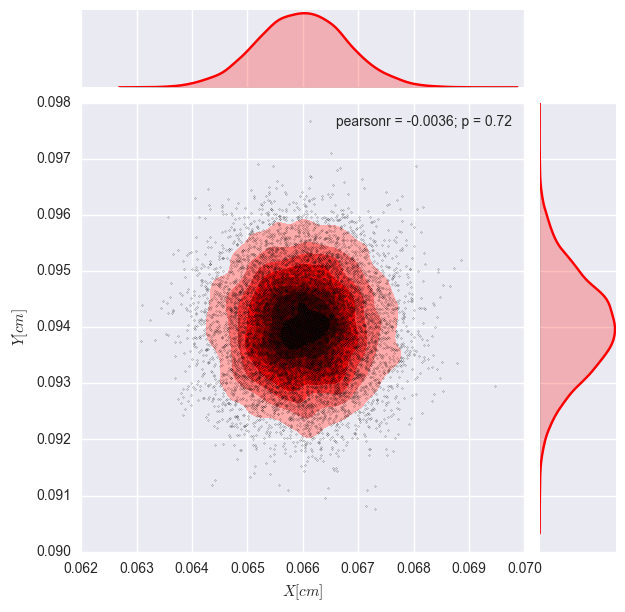

In [7]:
g = sns.jointplot(x=mvg[:,0], y=mvg[:,1], data=mvg, kind="kde", color="r")
g.plot_joint(plt.scatter, c="w", s=0.1, linewidth=1, marker=".")
g.ax_joint.collections[0].set_alpha(0)
g.set_axis_labels("$X [cm]$", "$Y [cm]$");
plt.xlim([0.062,0.070])
plt.ylim([0.090,0.098])
plt.show()

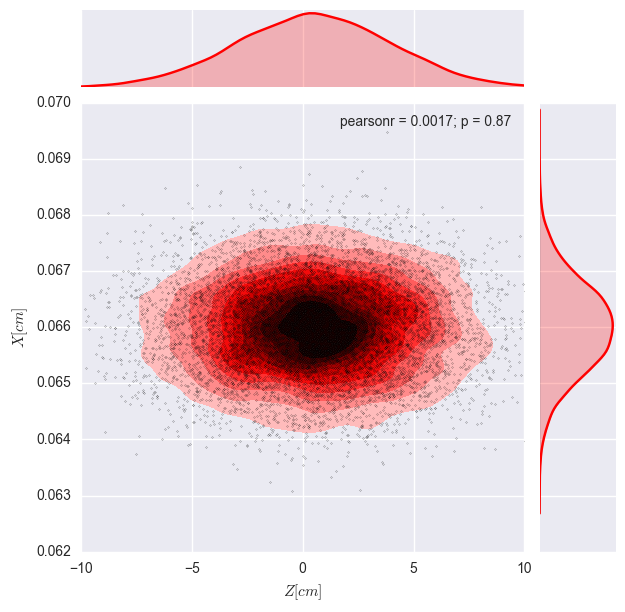

In [8]:
g = sns.jointplot(x=mvg[:,2], y=mvg[:,0], data=mvg, kind="kde", color="r")
g.plot_joint(plt.scatter, c="w", s=0.1, linewidth=1, marker=".")
g.ax_joint.collections[0].set_alpha(0)
g.set_axis_labels("$Z [cm]$", "$X [cm]$");
plt.xlim([-10,10])
plt.ylim([0.062,0.070])
plt.show()

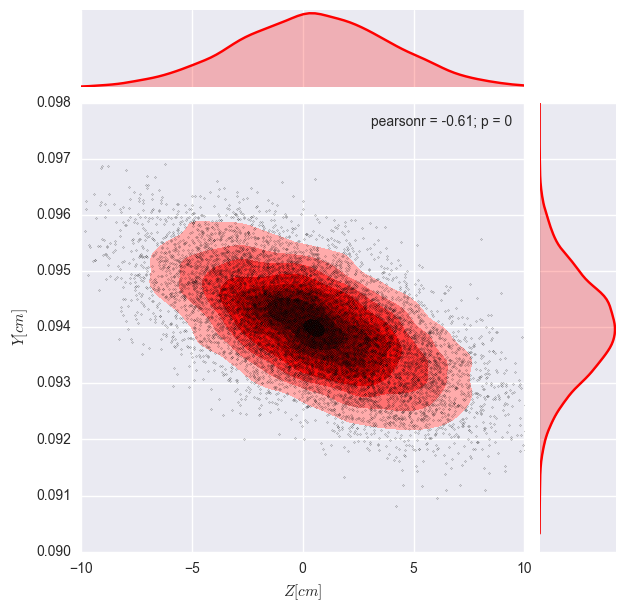

In [9]:
g = sns.jointplot(x=mvg[:,2], y=mvg[:,1], data=mvg, kind="kde", color="r")
g.plot_joint(plt.scatter, c="w", s=0.1, linewidth=1, marker=".")
g.ax_joint.collections[0].set_alpha(0)
g.set_axis_labels("$Z [cm]$", "$Y [cm]$");
plt.xlim([-10,10])
plt.ylim([0.090,0.098])
plt.show()

### Now let's fit with the CMS machinery!
(Never mind the ERROR/WARNING messages)

In [10]:
# create PVfitter object
beamspot = PVfitterCMS(mvg, verbose=False)

# fit
results = beamspot.fit()


FCN = -86578.4345162 
 TOTAL NCALL = 30 
 NCALLS = 30 
 
 
 EDM = 1.55478016422e-21 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,x,0.0659921,1.13332e-05,0,0,,,
2,y,0.0940064,1.23623e-05,0,0,,,
3,z,0.490547,0.0496965,0,0,,,
4,corrxy,0,1,0,0,,,FIXED
5,sigma_x_eff,0.000801381,1,0,0,,,FIXED
6,sigma_y_eff,0.000874148,1,0,0,,,FIXED
7,sigma_z_eff,3.51407,1,0,0,,,FIXED
8,dxdz,0,1,0,0,,,FIXED
9,dydz,0,1,0,0,,,FIXED


FCN = -86578.4345162 
 TOTAL NCALL = 52 
 NCALLS = 52 
 
 
 EDM = 1.47279923828e-08 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,x,0.0659921,1,0,0,,,FIXED
2,y,0.0940064,1,0,0,,,FIXED
3,z,0.490547,1,0,0,,,FIXED
4,corrxy,0,1,0,0,,,FIXED
5,sigma_x_eff,0.000801381,2.5116e-05,0,0,,,
6,sigma_y_eff,0.000874148,2.25745e-05,0,0,,,
7,sigma_z_eff,3.51407,0.0351406,0,0,,,
8,dxdz,0,1,0,0,,,FIXED
9,dydz,0,1,0,0,,,FIXED


FCN = -86578.4345162 
 TOTAL NCALL = 88 
 NCALLS = 88 
 
 
 EDM = 5.27470977469e-07 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 False 
 True 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,x,0.0659921,7.76388e-05,0,0,,,
2,y,0.0940064,6.76333e-06,0,0,,,
3,z,0.490547,0.0159807,0,0,,,
4,corrxy,0,1,0,0,,,FIXED
5,sigma_x_eff,0.000801381,0.000172058,0,0,,,
6,sigma_y_eff,0.000874148,1.23503e-05,0,0,,,
7,sigma_z_eff,3.51407,0.0113,0,0,,,
8,dxdz,0,1,0,0,,,FIXED
9,dydz,0,1,0,0,,,FIXED


FCN = -86578.4998974 
 TOTAL NCALL = 13 
 NCALLS = 13 
 
 
 EDM = 1.91584885252e-09 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,x,0.0659921,1,0,0,,,FIXED
2,y,0.0940064,1,0,0,,,FIXED
3,z,0.490547,1,0,0,,,FIXED
4,corrxy,-0.00361548,0.0141413,0,0,-1.0,1.0,
5,sigma_x_eff,0.000801381,1,0,0,,,FIXED
6,sigma_y_eff,0.000874148,1,0,0,,,FIXED
7,sigma_z_eff,3.51407,1,0,0,,,FIXED
8,dxdz,0,1,0,0,,,FIXED
9,dydz,0,1,0,0,,,FIXED


FCN = -88927.3601382 
 TOTAL NCALL = 52 
 NCALLS = 52 
 
 
 EDM = 1.41228147958e-08 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,x,0.0659921,1,0,0,,,FIXED
2,y,0.0940064,1,0,0,,,FIXED
3,z,0.490547,1,0,0,,,FIXED
4,corrxy,-0.00361548,1,0,0,,,FIXED
5,sigma_x_eff,0.000801381,1,0,0,,,FIXED
6,sigma_y_eff,0.000874148,1,0,0,,,FIXED
7,sigma_z_eff,3.51407,1,0,0,,,FIXED
8,dxdz,-3.8118e-07,2.54996e-06,0,0,-0.0004,0.0004,
9,dydz,-0.000152302,1.87561e-06,0,0,-0.0004,0.0004,


ERROR! NLL Minimization failed
WARNING! Singular covariance matrix, cannot invert!
WARNING! Singular covariance matrix, cannot invert!
WARNING! Singular covariance matrix, cannot invert!
WARNING! Singular covariance matrix, cannot invert!
WARNING! Singular covariance matrix, cannot invert!
WARNING! Singular covariance matrix, cannot invert!
WARNING! Singular covariance matrix, cannot invert!
WARNING! Singular covariance matrix, cannot invert!
WARNING! Singular covariance matrix, cannot invert!
WARNING! Singular covariance matrix, cannot invert!
WARNING! Singular covariance matrix, cannot invert!


/Users/manzoni/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:204: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
              x = +0.065992
              y = +0.094006
              z = +0.490547
         corrxy = -0.002515
    sigma_x_eff = +0.000862
    sigma_y_eff = +0.000469
    sigma_z_eff = +3.538181
           dxdz = -0.000001
           dydz = -0.000210

/Users/manzoni/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:204: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
              x = nan
              y = nan
              z = nan
         corrxy = nan
    sigma_x_eff = nan
    sigma_y_eff = nan
    sigma_z_eff = nan
           dxdz = nan
           dydz = nan



FCN = -88927.3601332 
 TOTAL NCALL = 307 
 NCALLS = 307 
 
 
 EDM = 4.27675736039e-06 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,x,0.0659921,1.12069e-05,0,0,,,
2,y,0.0940064,1.19254e-05,0,0,,,
3,z,0.490526,0.0485278,0,0,,,
4,corrxy,-0.00361547,0.0128845,0,0,-1.0,1.0,
5,sigma_x_eff,0.000801392,7.60826e-06,0,0,,,
6,sigma_y_eff,0.000874163,8.45981e-06,0,0,,,
7,sigma_z_eff,3.51407,0.0348277,0,0,,,
8,dxdz,-3.8183e-07,3.14787e-06,0,0,-0.0004,0.0004,
9,dydz,-0.000152306,2.69355e-06,0,0,-0.0004,0.0004,


ERROR! NLL Minimization failed


# Results

* $\sigma_x^{\textrm{eff}} = 8.0\pm0.08~\mu$m compatible with the _true_ width $\sigma_x = 8~\mu$m. This is expected as there's no $dx/dz$ tilt
* $\sigma_x^{\textrm{eff}} = 8.7\pm0.08~\mu$m 24% larger than the _true_ width $\sigma_y = 7~\mu$m. This is the expected effect of the $dy/dz$ tilt



## Generate the events with realistic parameters / 2
Now let's introduce some $xy$ correlation by means of a rotation of $\gamma = \pi/4$ radians along $z$ (maximise correlation)

In [11]:
# ---------- GENERATE EVENTS -----------
# generate events with somewhat realistic parameters
ntoys = 10000
      
# centroid position
pos = np.array([0.066, 0.094, 0.5,])

# build the covariance matrix from angles and widths
cov = MultivariateGaussianFitterNLL._compute_covariance_matrix(
    theta_x= 0.00015, #[rad]
    theta_y= 0., #[rad]
    theta_z= pi/4., #[rad]
    sigma_x= 0.0008, #[cm]
    sigma_y= 0.0007, #[cm]
    sigma_z= 3.5, #[cm]
)

# fix random seed
rng = np.random.RandomState(1986)

# generate multivariate normal
mvg = rng.multivariate_normal(pos, cov, ntoys)

print 'generated %d toys' %ntoys



generated 10000 toys


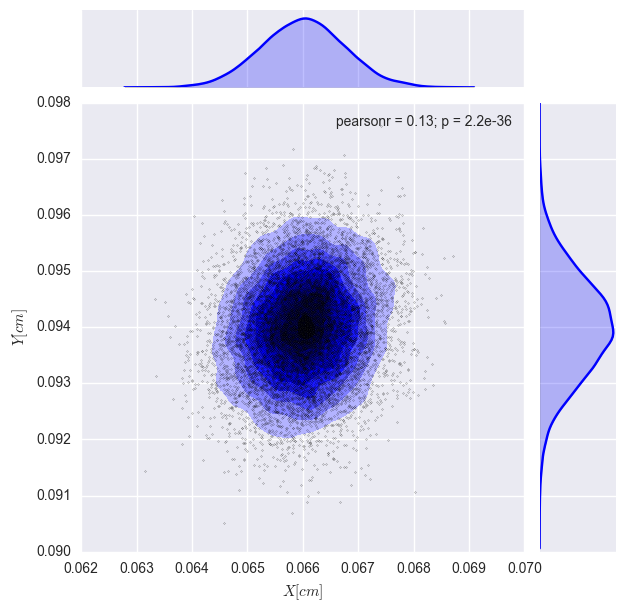

In [12]:
g = sns.jointplot(x=mvg[:,0], y=mvg[:,1], data=mvg, kind="kde", color="b")
g.plot_joint(plt.scatter, c="w", s=0.1, linewidth=1, marker=".")
g.ax_joint.collections[0].set_alpha(0)
g.set_axis_labels("$X [cm]$", "$Y [cm]$");
plt.xlim([0.062,0.070])
plt.ylim([0.090,0.098])
plt.show()

the tilt is visible although the two axes of the ellipsis have similar sizes

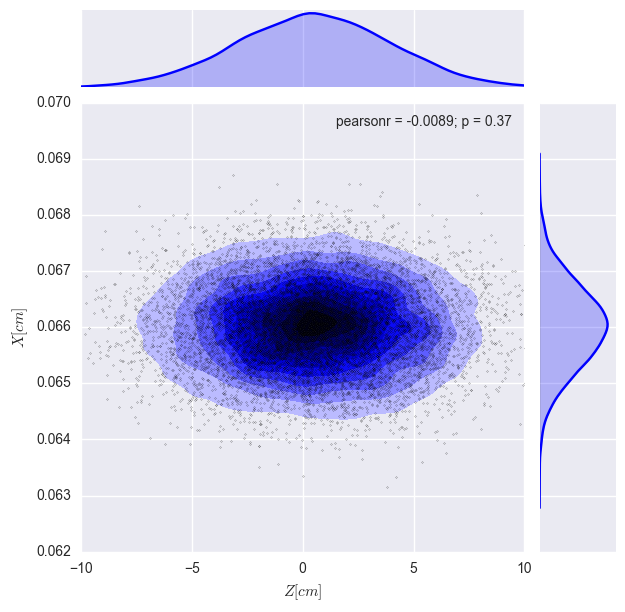

In [13]:
g = sns.jointplot(x=mvg[:,2], y=mvg[:,0], data=mvg, kind="kde", color="b")
g.plot_joint(plt.scatter, c="w", s=0.1, linewidth=1, marker=".")
g.ax_joint.collections[0].set_alpha(0)
g.set_axis_labels("$Z [cm]$", "$X [cm]$");
plt.xlim([-10,10])
plt.ylim([0.062,0.070])
plt.show()

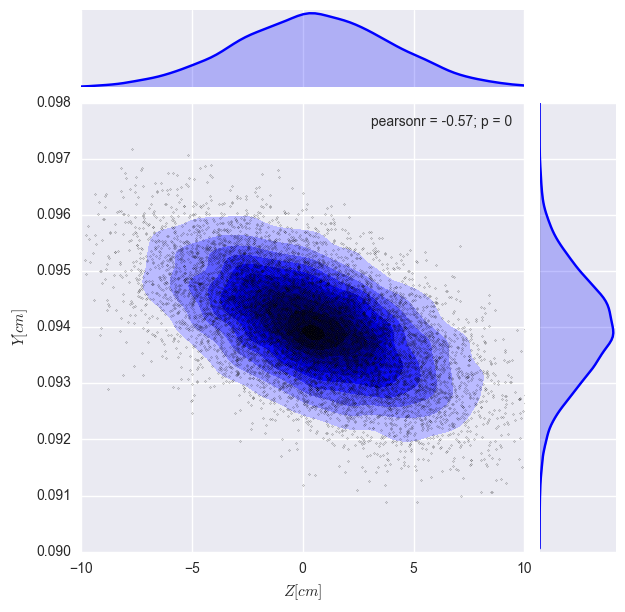

In [14]:
g = sns.jointplot(x=mvg[:,2], y=mvg[:,1], data=mvg, kind="kde", color="b")
g.plot_joint(plt.scatter, c="w", s=0.1, linewidth=1, marker=".")
g.ax_joint.collections[0].set_alpha(0)
g.set_axis_labels("$Z [cm]$", "$Y [cm]$");
plt.xlim([-10,10])
plt.ylim([0.090,0.098])
plt.show()

### Now let's fit with the CMS machinery! / 2
(Never mind the ERROR/WARNING messages)

In [15]:
# create PVfitter object
beamspot = PVfitterCMS(mvg, verbose=False)

# fit
results = beamspot.fit()

FCN = -86827.9154131 
 TOTAL NCALL = 30 
 NCALLS = 30 
 
 
 EDM = 1.52472667469e-21 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,x,0.0660091,1.06001e-05,0,0,,,
2,y,0.0940035,1.28917e-05,0,0,,,
3,z,0.490547,0.0496965,0,0,,,
4,corrxy,0,1,0,0,,,FIXED
5,sigma_x_eff,0.000749542,1,0,0,,,FIXED
6,sigma_y_eff,0.000911578,1,0,0,,,FIXED
7,sigma_z_eff,3.51407,1,0,0,,,FIXED
8,dxdz,0,1,0,0,,,FIXED
9,dydz,0,1,0,0,,,FIXED


ERROR! NLL Minimization failed
ERROR! NLL Minimization failed


/Users/manzoni/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:69: RuntimeWarning: Exception Occured 
fcn is called with following arguments:
              x = +0.066009
              y = +0.094004
              z = +0.490547
         corrxy = +0.000000
    sigma_x_eff = +0.000047
    sigma_y_eff = +0.000856
    sigma_z_eff = +3.514076
           dxdz = +0.000000
           dydz = +0.000000

/Users/manzoni/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:99: RuntimeWarning: Exception Occured 
fcn is called with following arguments:
              x = +0.066009
              y = +0.094004
              z = +0.490547
         corrxy = +0.000000
    sigma_x_eff = +0.000047
    sigma_y_eff = +0.000856
    sigma_z_eff = +3.514076
           dxdz = +0.000000
           dydz = +0.000000



FCN = -86907.2766015 
 TOTAL NCALL = 18 
 NCALLS = 18 
 
 
 EDM = 6.337641461e-07 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,x,0.0660091,1,0,0,,,FIXED
2,y,0.0940035,1,0,0,,,FIXED
3,z,0.490547,1,0,0,,,FIXED
4,corrxy,0.125498,0.0138105,0,0,-1.0,1.0,
5,sigma_x_eff,0.000749542,1,0,0,,,FIXED
6,sigma_y_eff,0.000911578,1,0,0,,,FIXED
7,sigma_z_eff,3.51407,1,0,0,,,FIXED
8,dxdz,0,1,0,0,,,FIXED
9,dydz,0,1,0,0,,,FIXED


FCN = -88927.3600931 
 TOTAL NCALL = 46 
 NCALLS = 46 
 
 
 EDM = 4.44256809312e-05 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,x,0.0660091,1,0,0,,,FIXED
2,y,0.0940035,1,0,0,,,FIXED
3,z,0.490547,1,0,0,,,FIXED
4,corrxy,0.125498,1,0,0,,,FIXED
5,sigma_x_eff,0.000749542,1,0,0,,,FIXED
6,sigma_y_eff,0.000911578,1,0,0,,,FIXED
7,sigma_z_eff,3.51407,1,0,0,,,FIXED
8,dxdz,1.88411e-06,2.46344e-06,0,0,-0.0004,0.0004,
9,dydz,-0.000148634,2.13386e-06,0,0,-0.0004,0.0004,


ERROR! NLL Minimization failed


FCN = -88927.3601376 
 TOTAL NCALL = 241 
 NCALLS = 241 
 
 
 EDM = 1.98832443777e-07 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,x,0.0660091,1.05163e-05,0,0,,,
2,y,0.0940035,1.27894e-05,0,0,,,
3,z,0.490547,0.0496951,0,0,,,
4,corrxy,0.125487,0.0139267,0,0,-1.0,1.0,
5,sigma_x_eff,0.000749544,7.4442e-06,0,0,,,
6,sigma_y_eff,0.00091158,9.00983e-06,0,0,,,
7,sigma_z_eff,3.51408,0.0347075,0,0,,,
8,dxdz,1.89834e-06,2.99905e-06,0,0,-0.0004,0.0004,
9,dydz,-0.000148641,2.98656e-06,0,0,-0.0004,0.0004,


ERROR! NLL Minimization failed


# Results / 2

* $\sigma_x^{\textrm{eff}} = 7.5\pm0.07~\mu$m, 0.5 $\mu$m smaller than the _true_ width $\sigma_x = 8~\mu$m
* $\sigma_x^{\textrm{eff}} = 8.8\pm0.09~\mu$m increases by an additional 0.1 $\mu$m

Given the low eccentricity ($\sigma_x \simeq \sigma_y$) of the transverse ellipsoid, even the maximal mixing ($\gamma=\pi/4$) has a small effect on the transverse widths compared to the tilts. 

# Conclusions

* CMS beam spot model fits for the _effective_ widths, which can differ significantly from the _true_ widths (in the luminous region reference frame) in case of dx/dz or dy/dz tilts.  
* Possible rotation along the beam axis can mix $\sigma_x$ and $\sigma_y$ but have a smaller impact.  
* The longitudinal widths is coarse and not affected by small tilts.
* the effective and true widths are related to each other through some algebra transformations (if I got the math right, the fact that the two expressions are not symmetric maybe indicates I didn't...):
$$(\sigma_x^{true})^2 = (\sigma_x^{eff})^2 - \bigg(\frac{dx}{dz}\bigg)^2(\sigma_z^{eff})^2$$  
$$(\sigma_y^{true})^2 = \bigg(\sigma_y^{eff} + \frac{dy}{dz}\sigma_z^{eff}\bigg)^2$$